In [421]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

In [422]:
def resetParameters():
    global timePerWord
    global retrievalTimeWord
    global retrievalTimeSentence
    global steeringUpdateTime
    global startingPositionInLane
    global gaussDeviateMean
    global gaussDeviateSD
    global gaussDriveNoiseMean
    global gaussDriveNoiseSD
    global timeStepPerDriftUpdate
    global maxLateralVelocity
    global minLateralVelocity
    global startvelocity
    global wordsPerMinuteMean
    global wordsPerMinuteSD

    timePerWord = 0  ### ms

    retrievalTimeWord = 200   #ms
    retrievalTimeSentence = 300 #ms

    steeringUpdateTime = 250    #in ms
    startingPositionInLane = 0.27 			#assume that car starts already away from lane centre (in meters)


    gaussDeviateMean = 0
    gaussDeviateSD = 0.13 ##in meter/sec
    gaussDriveNoiseMean = 0
    gaussDriveNoiseSD = 0.1	#in meter/sec
    timeStepPerDriftUpdate = 50 ### msec: what is the time interval between two updates of lateral position?
    maxLateralVelocity = 1.7	# in m/s: maximum lateral velocity: what is the maximum that you can steer?
    minLateralVelocity = -1* maxLateralVelocity
    startvelocity = 0 	#a global parameter used to store the lateral velocity of the car
    wordsPerMinuteMean = 39.33
    wordsPerMinuteSD = 10.3

In [423]:
##calculates if the car is not accelerating (m/s) more than it should (maxLateralVelocity) or less than it should (minLateralVelocity)  (done for a vector of numbers)
def velocityCheckForVectors(velocityVectors):
    global maxLateralVelocity
    global minLateralVelocity

    velocityVectorsLoc = velocityVectors

    if (type(velocityVectorsLoc) is list):
            ### this can be done faster with for example numpy functions
        velocityVectorsLoc = velocityVectors
        for i in range(len(velocityVectorsLoc)):
            if(velocityVectorsLoc[i]>1.7):
                velocityVectorsLoc[i] = 1.7
            elif (velocityVectorsLoc[i] < -1.7):
                velocityVectorsLoc[i] = -1.7
    else:
        if(velocityVectorsLoc > 1.7):
            velocityVectorsLoc = 1.7
        elif (velocityVectorsLoc < -1.7):
            velocityVectorsLoc = -1.7

    return velocityVectorsLoc  ### in m/s

In [424]:
## Function to determine lateral velocity (controlled with steering wheel) based on where car is currently positioned. See Janssen & Brumby (2010) for more detailed explanation.
## Lateral velocity update depends on current position in lane. Intuition behind function: the further away you are, the stronger the correction will be that a human makes
def vehicleUpdateActiveSteering(LD):
	latVel = 0.2617 * LD*LD + 0.0233 * LD - 0.022
	returnValue = velocityCheckForVectors(latVel)
	return returnValue ### in m/s

In [425]:
from scipy.stats import norm

def normal_sample(mean,std):
    #x = 1.96  # value at which to evaluate the CDF
    rng = np.random.default_rng()
    return rng.normal(loc=mean, scale=std, size=1)

In [426]:
def vehicleDrift():
    driftSpeed = normal_sample(gaussDeviateMean,gaussDeviateSD)
    return velocityCheckForVectors(driftSpeed)

In [427]:
import math

In [436]:
### Function to run a trial. Needs to be defined by students (section 2 and 3 of assignment)
import pandas as pd

def runTrial(nrWordsPerSentence =17,nrSentences=10,nrSteeringMovementsWhenSteering=4, interleaving="word"):
    resetParameters()
    #locPos = []
    #locTime = []
    #locColor = []
    simulation_data = []
    id = 0

    totalTrailTime = 0
    properTime = 0
    trailTime = 0

    carPos = 0
    carPos = startingPositionInLane
    print(carPos)



    wordsPerMinute = normal_sample(wordsPerMinuteMean,wordsPerMinuteSD)
    timePerWord = ( 60 / wordsPerMinute ) * 1000

    totalRunTime = 461750 #ms
    totalRunSteps = math.floor(461750 / 50)

    if interleaving == "none":
        for sentence in range(nrSentences):
            for word in range(nrWordsPerSentence):

                trailTime = 0
                if word == 0: trailTime += retrievalTimeSentence
                trailTime += retrievalTimeWord
                trailTime += timePerWord

                driftUpdates = math.floor(trailTime / 50)

                for dr in range(driftUpdates):
                    driftAmount = vehicleDrift()
                    carPos = carPos + driftAmount/20

                    simulation_data.append({
                        "Time": properTime,
                        "Position": carPos,
                        "Color": "red"  # Drifting
                    })

                    properTime += 50

                totalTrailTime += trailTime

    if interleaving == "drivingOnly":
        drivingTrailTime = 0
        for tstep in range(totalRunSteps):
            for steering in range(nrSteeringMovementsWhenSteering):
                steeringAmount = vehicleUpdateActiveSteering(carPos) * 0.05

                if carPos > 0:
                    carPos = carPos - steeringAmount
                else:
                    carPos = carPos + steeringAmount

                simulation_data.append({
                    "Time": properTime,
                    "Position": carPos,
                    "Color": "blue"  # Steering
                })

                properTime += 50
                drivingTrailTime += 50

            totalTrailTime += drivingTrailTime

    if interleaving == "sentence":
        for sentence in range(nrSentences):
            sentenceTrailTime = 0

            for word in range(nrWordsPerSentence):
                trailTime = 0

                if word == 0: trailTime += retrievalTimeSentence
                #trailTime += retrievalTimeWord
                trailTime += timePerWord
                sentenceTrailTime += timePerWord
                #print(trailTime)

                driftUpdates = math.floor(trailTime / 50)
                #print(driftUpdates)

                for dr in range(driftUpdates):
                    driftAmount = vehicleDrift()
                    carPos = carPos + driftAmount/20

                    simulation_data.append({
                        "Time": properTime,
                        "Position": carPos,
                        "Color": "red"  # Drifting
                    })

                    properTime += 50


            for steering in range(nrSteeringMovementsWhenSteering):
                steeringAmount = vehicleUpdateActiveSteering(carPos) * 0.25
                #print(steeringAmount)

                if carPos > 0:
                    carPos = carPos - steeringAmount
                else:
                    carPos = carPos + steeringAmount

                simulation_data.append({
                    "Time": properTime,
                    "Position": carPos,
                    "Color": "blue"  # Steering
                })

                properTime += 250
                sentenceTrailTime += 250

            totalTrailTime += sentenceTrailTime

    if interleaving == "word":
        for sentence in range(nrSentences):
            for word in range(nrWordsPerSentence):
                trailTime = 0

                #locPos.append(carPos)
                #locColor.append("red")
                #locTime.append(properTime)
                #frame.append([carPos.value],["red"],[properTime])

                if word == 0: trailTime += retrievalTimeSentence
                trailTime += retrievalTimeWord
                trailTime += timePerWord
                #print(trailTime)

                driftUpdates = math.floor(trailTime / 50)
                #print(driftUpdates)

                for dr in range(driftUpdates):
                    driftAmount = vehicleDrift()
                    carPos = carPos + driftAmount/20

                    simulation_data.append({
                        "Time": properTime,
                        "Position": carPos,
                        "Color": "red"  # Drifting
                    })

                    properTime += 50

                for steering in range(nrSteeringMovementsWhenSteering):
                    steeringAmount = vehicleUpdateActiveSteering(carPos) * 0.25
                    #print(steeringAmount)

                    if carPos > 0:
                        carPos = carPos - steeringAmount
                    else:
                        carPos = carPos + steeringAmount

                    simulation_data.append({
                        "Time": properTime,
                        "Position": carPos,
                        "Color": "blue"  # Steering
                    })

                    properTime += 250
                    trailTime += 250

                totalTrailTime += trailTime
    else:
        print("okay")

    df = pd.DataFrame(simulation_data)

    #print(df)
    if df['Position'].dtype == 'string':
        df['Position'] = df['Position'].str[0].astype(float)

    df['Position'] = df['Position'].apply(lambda x: float(x[0]))

    output_totalTime = df['Time'].iloc[-1]
    output_meanDeviation = df['Position'].mean()
    output_maxDeviation = df['Position'].max()
    output_strat = interleaving

    output_vec = [output_totalTime, output_meanDeviation, output_maxDeviation, output_strat]

    return output_vec


In [437]:
trailData = runTrial()
print(trailData)

0.27


C:\Users\Luc\AppData\Local\Temp\ipykernel_10624\4214049775.py:139: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  driftUpdates = math.floor(trailTime / 50)


[597750, 0.23615310085229707, 0.43416925252460087, 'word']


In [429]:
### function to run multiple simulations. Needs to be defined by students (section 3 of assignment)
def runSimulations(nrSims = 10):
    for sim in range(nrSims):
        trailData = runTrial()

        #res = drawPlot(sim,trailData)
        #res.savefig(r'C:\Users\Luc\PycharmProjects\CognitiveMod\figs2\Q2bPlot'+ str(sim) +'.png', dpi=300)
        #print("saved_succesfully")

text_total_trail_time = trailData['Time'].iloc[-1]
text_mean_pos_road = trailData['Position'].mean()
text_max_pos_road = trailData['Position'].max()

text_total_trail_time = f"{text_total_trail_time:.2f}"
text_mean_pos_road = f"{text_mean_pos_road:.3f}"
text_max_pos_road = f"{text_max_pos_road:.3f}"
text_max_pos_road

In [431]:
# This plotting code now works correctly with the clean `trailData` DataFrame

def drawPlot(indexx,drawData):
    plt.figure(figsize=(15, 7))

    # Use seaborn's scatterplot function



    scatter = sb.scatterplot(data=drawData, x='Time', y='Position', hue='Color', palette={'red': 'r', 'blue': 'b'}, s=10)

    # --- Add Enhancements for Clarity ---
    # Add horizontal lines to represent the lane edges
    plt.axhline(y=1.6, color='black', linestyle='--', label='Lane Edge')
    plt.axhline(y=-1.6, color='black', linestyle='--')
    plt.axhline(y=0, color='black', linestyle='-',alpha=0.5)

    # Add titles and labels
    plt.title('Simulated Car Lateral Position Over Time', fontsize=16)
    plt.xlabel('Time (ms)', fontsize=12)
    plt.ylabel('Lateral Position from Center (m)', fontsize=12)

    # Add a legend and a grid
    plt.legend()
    new_labels = ['drifting', 'steering']
    handles, old_labels = scatter.get_legend_handles_labels()
    plt.legend(handles, new_labels, title="Movement", loc='best')
    plt.grid(True, which='both', linestyle='-', linewidth=0.5)

    plt.text(0.5, 1.2, "Total trail time: " + str(text_total_trail_time), fontsize=12, color='black')
    plt.text(0.5, 1.0, "Average position road: " + str(text_mean_pos_road), fontsize=12, color='black')
    plt.text(0.5, 0.8, "Max position road: " + str(text_max_pos_road), fontsize=12, color='black')

    # Display the plot

    fig = scatter.get_figure()

    plt.show()
    return fig

In [432]:
#runSimulations()

0.27


C:\Users\Luc\AppData\Local\Temp\ipykernel_10624\1841727381.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  driftUpdates = math.floor(trailTime / 50)


okay


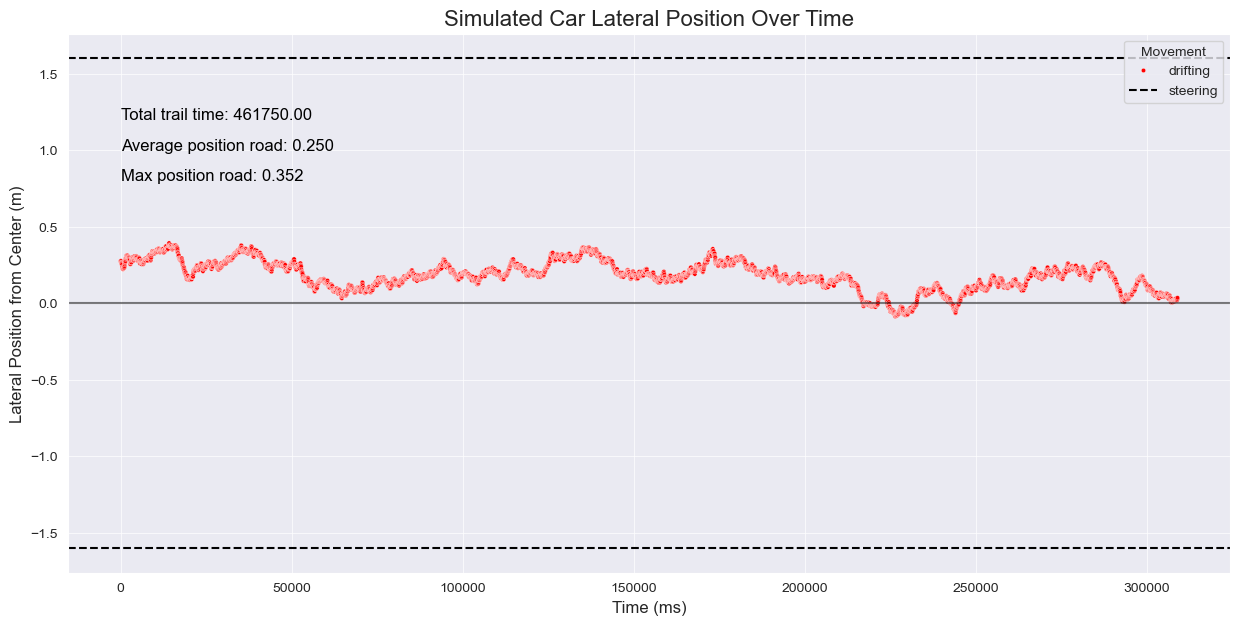

In [433]:
#trailDataTemp = runTrial(interleaving='none')
#res = drawPlot(0,trailDataTemp)